In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

/home/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128 #rodrigues = BATCH_SIZE = 64
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [3]:
label_names = np.asarray(['highway','insidecity','tallbuilding','street','forest','coast','mountain','opencountry'])
folder = "./LabelMe/"

### Load Data and preprocess

In [4]:
X_train_vgg16 = np.load(folder+"LabelMe_VGG_avg_train.npy")
Z_train = np.loadtxt(folder+"LabelMe_Z_train.txt",dtype='int')

X_val_vgg16 = np.load(folder+"LabelMe_VGG_avg_valid.npy")
Z_val = np.loadtxt(folder+"LabelMe_Z_valid.txt",dtype='int')

X_test_vgg16 = np.load(folder+"LabelMe_VGG_avg_test.npy")
Z_test = np.loadtxt(folder+"LabelMe_Z_test.txt",dtype='int')

print("Input shape:",X_train_vgg16.shape)
print("Label shape:",Z_train.shape)

Input shape: (1000, 512)
Label shape: (1000,)


In [5]:
Xstd_train = X_train_vgg16
Xstd_val = X_val_vgg16
Xstd_test = X_test_vgg16

In [6]:
from sklearn.preprocessing import StandardScaler
std= StandardScaler(with_mean=False,with_std=False)  #do it ??
std.fit(X_train_vgg16)
Xstd_train = std.transform(X_train_vgg16)
Xstd_val = std.transform(X_val_vgg16)
Xstd_test = std.transform(X_test_vgg16)
Xstd_train.shape

(1000, 512)

### Load annotations / Generate

In [6]:
from code.representation import *
from code.utils import *

# data from Amazon Mechanical Turk
print("Loading AMT data...")
y_obs = np.loadtxt(folder+"answers.txt",dtype='int16') #not annotation symbol ==-1
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

print("Remove %d annotators that do not annotate on this set "%(np.sum(T_weights==0)))
y_obs = y_obs[:,T_weights!=0]
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

Loading AMT data...
Remove 18 annotators that do not annotate on this set 
Shape (data,annotators):  (1000, 59)
Classes:  8


In [7]:
#every annotation is one annotator
total_annotations = T_weights.sum(axis=0)
new_annotations = np.ones((N, total_annotations),dtype='int16')*-1
t_aux = 0
for i in range(y_obs.shape[0]):
    for t in range(y_obs.shape[1]):
        if y_obs[i,t] != -1:
            new_annotations[i,t_aux] = y_obs[i,t]
            t_aux+=1
new_annotations.shape

(1000, 2547)

In [27]:
#perturbe annotations by annotators
total_annotations = T_weights.sum(axis=0)

new_annotations = np.ones((N, 20000),dtype='int16')*-1
new_annotations[:,:T] = y_obs

for new_t in range(T,new_annotations.shape[1]):
    t_select = np.random.randint(T)
    
    t_aux = np.random.poisson(10) #1 #values left-- change value to remove few annotators
    mask_bin = (np.random.multinomial(t_aux, np.tile(1./N,N)) != 0)
    
    new_annotator = mask_bin*(y_obs[:,t_select]+1) -1 #new annotations of annotator generated
    new_annotations[:,new_t] = new_annotator
    
T_weights = np.sum(new_annotations != -1,axis=0) #distribucion de anotaciones
print("Remove %d annotators that do not annotate on this set "%(np.sum(T_weights==0)))
new_annotations = new_annotations[:,T_weights!=0]
new_annotations.shape

Remove 13928 annotators that do not annotate on this set 


(1000, 6072)

In [30]:
np.savetxt(folder+"answers_v3.txt",new_annotations, delimiter=",", fmt="%i")

In [7]:
#generate conf matrix...
confe_matrix_R = np.zeros((T,K,K),dtype=DTYPE_OP) #rodrigues add epsilon here
for t in range(T):    
    for i in range(N):
        if y_obs[i,t] != -1:
            confe_matrix_R[t,Z_train[i],y_obs[i,t]] +=1
            
    mask_nan = confe_matrix_R[t,:,:].sum(axis=-1) == 0
    mean_replace = np.mean(confe_matrix_R[t,:,:][~mask_nan],axis=0)
    for value in np.arange(K)[mask_nan]:
        #how to fill where she not annotate?? -- 
        confe_matrix_R[t,value,:] =  1 #Rodrigues 1./K -- similar  to laplace smooth (prior 1)
        #confe_matrix[t,value,:] = mean_replace #Ours
    confe_matrix_R[t,:,:] = confe_matrix_R[t,:,:]/confe_matrix_R[t,:,:].sum(axis=-1,keepdims=True) #normalize
confe_matrix_R

array([[[0.7777778 , 0.11111111, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.78571427, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.23076923, 0.7692308 , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         1.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.05555556,
         0.22222222, 0.5555556 ]],

       [[1.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.125     , 0.125     , 0.125     , ..., 0.125     ,
         0.125     , 0.125     ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        ,
         0.        , 0.        ],
        [0. 

In [8]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

NameError: name 'sns' is not defined

#### Delta Convergence criteria

In [8]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [10]:
Z_train_onehot = keras.utils.to_categorical(Z_train)
Z_val_onehot = keras.utils.to_categorical(Z_val)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,1,BN=False,drop=0.5) #true bn?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback]
                  ,validation_data=(Xstd_val,Z_val_onehot))
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_UB.predict_classes(Xstd_train)
Z_test_pred = model_UB.predict_classes(Xstd_test)

Trained IDeal Model, Epochs to converge = 13


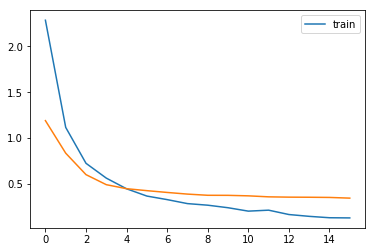

In [46]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

### Infer Labels (without predictive model)

In [11]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')

mv_probas, mv_conf_probas = label_I.mv_labels('probas')
mv_onehot, mv_conf_onehot = label_I.mv_labels('onehot')

confe_matrix_G = get_Global_confusionM(Z_train,label_I.y_obs_repeat)

if y_obs.shape[1] <= 12000:
    ds_labels,ds_conf = label_I.DS_labels()

Representation for MV in 0.138425 sec
Representation for DS in 0.108595 sec
Estimation MV in 0.000303 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -2837.162198697235
2 	 -2760.5637733289814 	0.0216	0.166209	0.026998
3 	 -2734.590823208355 	0.0124	0.062463	0.009409
4 	 -2723.3804042488773 	0.0073	0.061532	0.004099
5 	 -2717.719491028206 	0.0045	0.054811	0.002079
6 	 -2714.517475271211 	0.0031	0.043390	0.001178
7 	 -2712.6729434426734 	0.0022	0.033013	0.000680
8 	 -2711.508835118107 	0.0017	0.026319	0.000429
Class marginals
[0.08 0.11 0.14 0.11 0.14 0.14 0.17 0.09]
Estimation for DS in 2.092380 sec


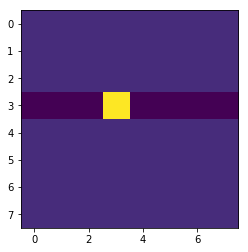

In [40]:
plt.imshow(confe_matrix[0])

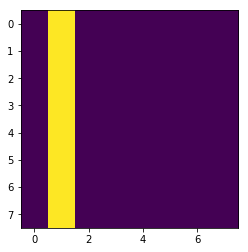

In [17]:
plt.imshow(ds_conf[3])

In [12]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.769
ACC D&S on train: 0.804


In [13]:
#check ds with  theones come with data
aux = np.loadtxt("./LabelMe/answers_DS.txt",dtype='int')
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train)) #calculated by Rodrigues (until converge)
print("Similaririty between ours and his: ",np.mean(ds_labels.argmax(axis=1) == aux))

ACC D&S on train: 0.804
Similaririty between ours and his:  0.966


In [14]:
model_mvsoft = keras.models.clone_model(model_UB)
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(Xstd_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvsoft.predict_classes(Xstd_train)
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)

Trained model over soft-MV, Epochs to converge = 8


In [19]:
model_mvhard = keras.models.clone_model(model_UB)
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvhard.predict_classes(Xstd_train)
Z_test_pred = model_mvhard.predict_classes(Xstd_test)

Trained model over hard-MV, Epochs to converge = 16


In [21]:
model_ds = keras.models.clone_model(model_UB)
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_ds.predict_classes(Xstd_train)
Z_test_pred = model_ds.predict_classes(Xstd_test)

Trained model over D&S, Epochs to converge = 9


### Raykar Model (joint predict model)

In [15]:
from code.baseline import RaykarMC
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (1000, 59, 8)


In [23]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("mlp",128,1,BatchN=False,drop=0.5) #otro

logL_hists,i_r = raykarMC.multiples_run(20,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 0.73 sec)	logL: -2783.629	
Iter 2/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -2539.641	Tol1: 0.08765	Tol2: 0.07841	
Iter 3/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -2441.706	Tol1: 0.03856	Tol2: 0.03432	
Iter 4/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -2392.792	Tol1: 0.02003	Tol2: 0.02383	
Finished training
Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 0.57 sec)	logL: -3018.285	
Iter 2/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -2616.592	Tol1: 0.13309	Tol2: 0.09052	
Iter 3/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -2476.000	Tol1: 0.05373	Tol2: 0.03688	
Iter 4/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -2411.917	Tol1: 0.02588	Tol2: 0.02278	
Finished training
Initializi

In [24]:
Z_train_p = raykarMC.base_model.predict(Xstd_train)
Z_train_pred =Z_train_p.argmax(axis=-1)
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)

Bayesian gaussian mixture say is 20 clusters 


/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt

DBSCAN say is 2 clusters
Affinity Propagation say is 1 clusters
Annotators PCA of annotations shape:  (5197, 4)


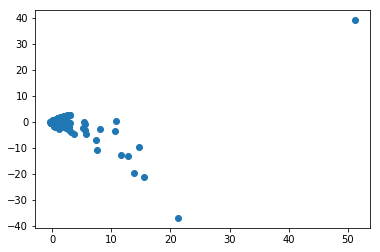

In [12]:
## cluster annotations?
from sklearn.preprocessing import StandardScaler
from code.MixtureofGroups import project_and_cluster,clusterize_annotators
annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,mode_project='pca')[0]
print("Annotators PCA of annotations shape: ",annotators_pca.shape)

std = StandardScaler(with_mean=True,with_std=True)
annotators_pca2 = std.fit_transform(annotators_pca)
plt.scatter(annotators_pca2[:,0],annotators_pca2[:,1])
plt.show()

### Our Proposed

In [9]:
from code.MixtureofGroups import GroupMixtureOpt

""" AÑADIR A ARCHIVO GROUPS..."""
def define_uniform_groups(power,r,M):
    R_total = r.sum()
    uniform_groups = np.asarray([power*R_total/M for _ in range(M)])
    return uniform_groups


#get our representation 
r_obs = set_representation(y_obs,"repeat")
#r_obs = label_I.y_obs_repeat.copy()

confe_matrix_G = get_Global_confusionM(Z_train,r_obs)

print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[0 2 0 ... 0 0 0]
 [0 1 2 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 [0 0 0 ... 0 0 2]]
shape: (1000, 8)


Normalized entropy (0-1) of repeats annotations: 0.11212816116784208


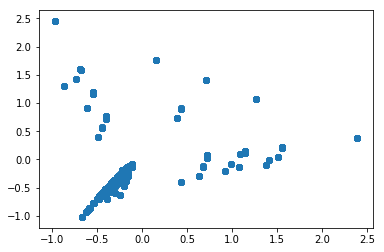

In [14]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

from code.MixtureofGroups import *
predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()

There is low entropy (information), maybe there is only a few groups in this dataset, the possible of different behavior is low.

Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.005396 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7649964  0.35427967 0.05306005 0.08938941 0.32689986]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/0
M step: done,  E step: done //  (in 0.57 sec)	logL: -7404.934	
Finished training!


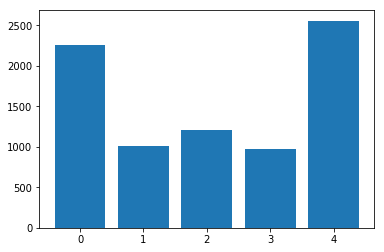

<BarContainer object of 5 artists>

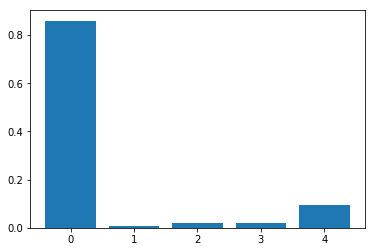

In [16]:
gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=5,epochs=0,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)
gMixture_Global.lambda_random = True 
logL_hists,i_r = gMixture_Global.multiples_run(1,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=0,tolerance=TOL
                               ,cluster=True)

aux = gMixture_Global.alpha_init.sum(axis=1).sum(axis=0)
plt.bar(np.arange(gMixture_Global.M),aux)
plt.show()
gMixture_Global.get_alpha()
plt.bar(np.arange(gMixture_Global.M),gMixture_Global.get_alpha())

In [31]:
#select M based on JS on train and accuracy on val (as train has ground truth can evaluate JS)
from code.evaluation import Evaluation_metrics
logL_Mchange = []
accTR_Mchange = []
accTE_Mchange = []
best_group_acc_Mchange = []
probas_Mchange = []
divergence1_Mchange = [] #JS Weighted
divergence2_Mchange = [] #JS
probGt_Mchange = []
inertia_Mchange = [] 

uniform_groups = define_uniform_groups(0.1, r_obs, M_seted)
uniform = True
for M_seted in range(1,10+1):
    for _ in range(10):
        gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
        gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)
        
        if uniform:
            #to uniform groups...
            gMixture_Global.define_priors("laplace")
            gMixture_Global.define_priors(uniform_groups) 
        
        gMixture_Global.lambda_random = True 
        logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                       ,cluster=True)
        
        print("Model with %d trained"%(M_seted))
        logL_Mchange.append(logL_hists[i_r])
        probas_Mchange.append(gMixture_Global.get_alpha())

        #measure metrics..
        evaluate = Evaluation_metrics(gMixture_Global,'our1',plot=False) 
        aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False)
        predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
        Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
        results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,y_o=y_obs)

        accTR_Mchange.append(results1[0]["Accuracy"][0])
        divergence1_Mchange.append(results1[0]["Mean NormF"][0])
        divergence2_Mchange.append(results1[0]["Mean JS"][0])
        probGt_Mchange.append(prob_Gt)

        c_M = gMixture_Global.get_confusionM()
        y_o_groups = gMixture_Global.get_predictions_groups(Xstd_val).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
        Z_val_pred = gMixture_Global.base_model.predict_classes(Xstd_val)
        results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred,conf_pred=c_M, y_o_groups=y_o_groups)

        best_group_acc_Mchange.append(np.max(results2[0]["Accuracy"]))
        accTE_Mchange.append(results2[1]["Accuracy"][0])
        inertia_Mchange.append(evaluate.inertia)
        
        del gMixture_Global,logL_hists,evaluate,predictions_m,prob_Gt,prob_Yzt,Z_train_pred,results1,results2,Z_val_pred
        gc.collect()
        keras.backend.clear_session()
# cada 10 obtener promedio
T_models = 9
R = 10
logL_Mchange = [np.mean( [value[-1] for value in logL_Mchange[i*R:(i+1)*R] ] ) for i in range(T_models)]
accTR_Mchange = [np.mean(accTR_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
accTE_Mchange = [np.mean(accTE_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
best_group_acc_Mchange = [np.mean(best_group_acc_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
probas_Mchange = [np.mean(probas_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
divergence1_Mchange = [np.mean(divergence1_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
divergence2_Mchange = [np.mean(divergence2_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
probGt_Mchange = [np.mean(probGt_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
inertia_Mchange = [np.mean(inertia_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]

Needed params (units,deep,drop,BatchN?)
Remember to prior bethas
Doing clustering...Done!
Get init alphas in 0.003649 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.29]
Alphas:  (1,)
MV init:  (1000, 8)
Betas:  (1, 8, 8)
Q estimate:  (1000, 8, 1, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.69 sec)	logL: -3260.276	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2203.735	Tol1: 0.32406	Tol2: 0.70936	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1987.212	Tol1: 0.09825	Tol2: 0.15927	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1902.811	Tol1: 0.04247	Tol2: 0.11973	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1853.444	Tol1: 0.02594	Tol2: 0.06754	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1775.781	Tol1: 0.04190	Tol2: 0.05046	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL:

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Needed params (units,deep,drop,BatchN?)
Remember to prior bethas
Doing clustering...Done!
Get init alphas in 0.003971 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.59]
Alphas:  (1,)
MV init:  (1000, 8)
Betas:  (1, 8, 8)
Q estimate:  (1000, 8, 1, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -3011.392	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2115.873	Tol1: 0.29738	Tol2: 0.39124	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1924.810	Tol1: 0.09030	Tol2: 0.18874	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1853.941	Tol1: 0.03682	Tol2: 0.14168	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1779.691	Tol1: 0.04005	Tol2: 0.10433	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1732.332	Tol1: 0.02661	Tol2: 0.07472	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL:

/users/fmena/MixtureofGroups/code/utils.py:285: RuntimeWarning: invalid value encountered in true_divide
  entropy_values = [entropy(value)/np.log(len(value)) for value in probas_Mchange]


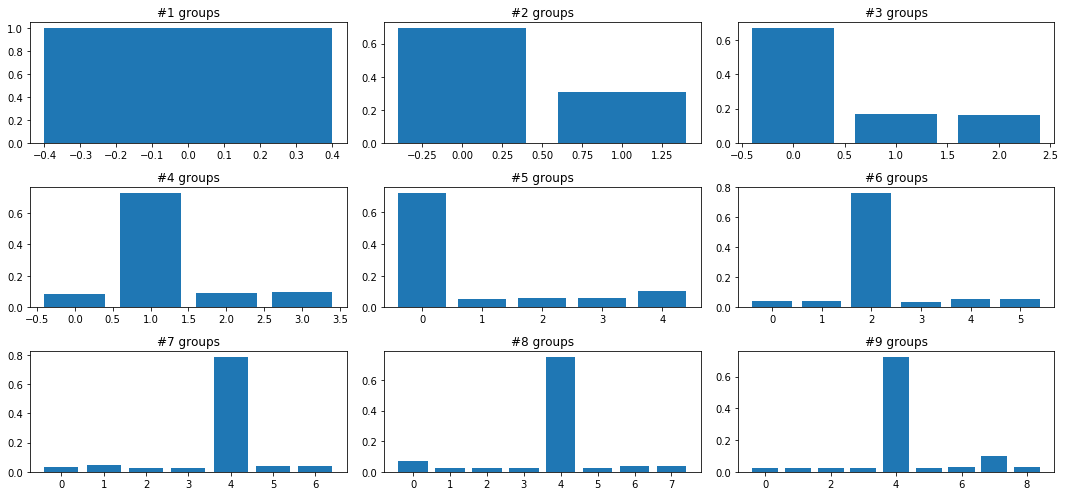

<Figure size 1080x360 with 0 Axes>

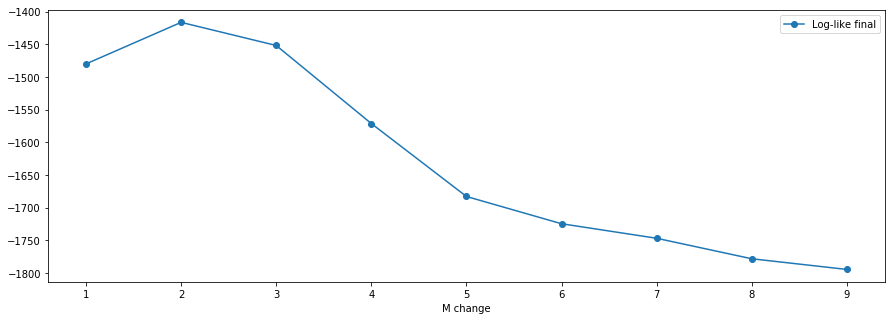

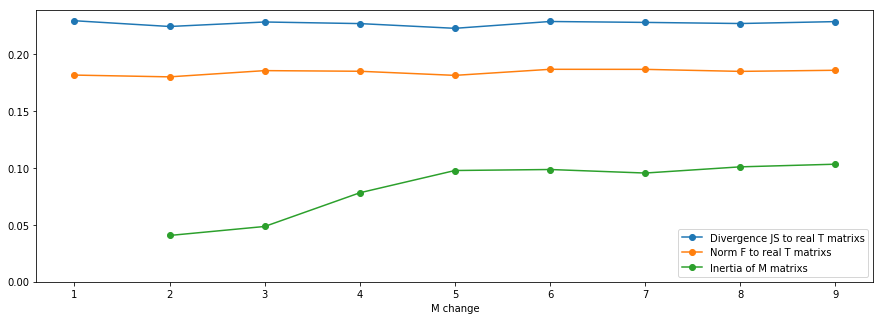

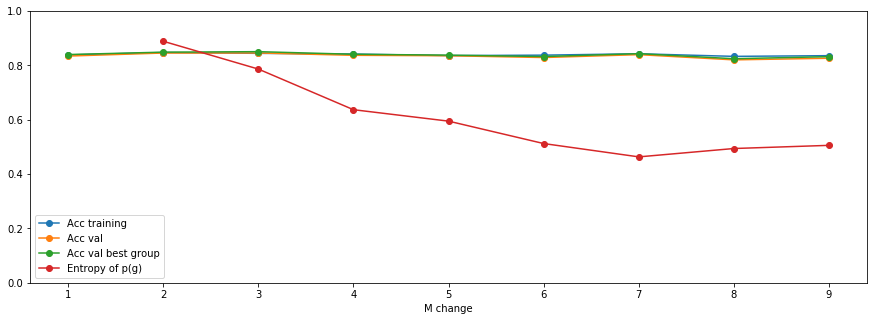

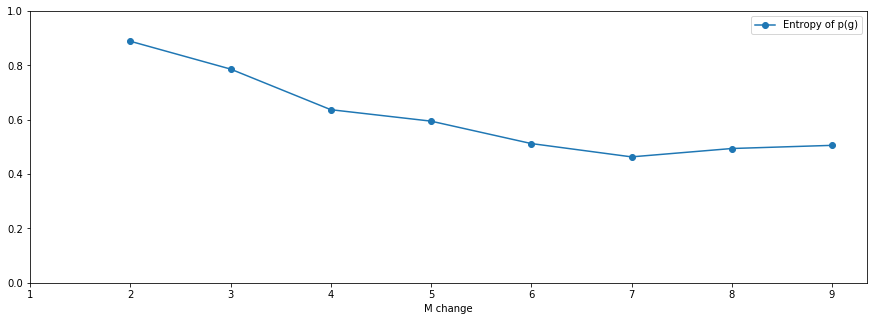

In [32]:
plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
             divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange
            )

In [17]:
#T if i know T
print(T)
M_values = range(1,1+len(logL_Mchange))
t = pd.DataFrame()
t["#Groups"] = M_values
t[">=1 annotator"] = [ np.sum(probas*T >= 1) for probas in probas_Mchange]
t[">=2 annotator"] = [ np.sum(probas*T >= 2) for probas in probas_Mchange] #si agrupa al menos tiene 2
t["Used on annotators"] = [ len(np.unique(prob_Gt.argmax(axis=1))) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.01"] = [ np.sum(prob_Gt.max(axis=0)>=0.01) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.05"] = [ np.sum(prob_Gt.max(axis=0)>=0.05) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t

59


#Groups  >=1 annotator  >=2 annotator  Used on annotators  \
0        1              1              1                   1   
1        2              1              1                   1   
2        3              1              1                   1   
3        4              2              1                   1   
4        5              1              1                   1   
5        6              1              1                   1   
6        7              2              1                   1   
7        8              2              2                   1   
8        9              2              1                   1   

   Used on annotators limit >=0.01  Used on annotators limit >=0.05  
0                                1                                1  
1                                1                                1  
2                                1                                1  
3                                2                                1  
4                                1                                1  
5                                1                                1  
6                                2                                1  
7                                2                                2  
8                                2                                1

1, 2 o 3...

In [10]:
M_seted = 3 #??

uniform = False
if uniform:
    uniform_groups = define_uniform_groups(0.1, r_obs, M_seted)
    print(uniform_groups)

In [11]:
gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)
if uniform:
    gMixture_Global.define_priors("laplace")
    gMixture_Global.define_priors(uniform_groups)

gMixture_Global.lambda_random = True 
logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)

Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.002065 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.97275084 0.9789678  0.31837186]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.63 sec)	logL: -2832.163	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2152.967	Tol1: 0.23982	Tol2: 0.30747	Tol3: 0.08074	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1974.593	Tol1: 0.08285	Tol2: 0.10983	Tol3: 0.21584	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1873.182	Tol1: 0.05136	Tol2: 0.07577	Tol3: 0.22995	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1815.078	Tol1: 0.03102	Tol2: 0.05564	Tol3: 0.22618	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1764.680	Tol1: 0.02777	Tol2: 0.03270	Tol3: 0.20610	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	lo

In [12]:
Z_train_p = gMixture_Global.base_model.predict(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Global.base_model.predict(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

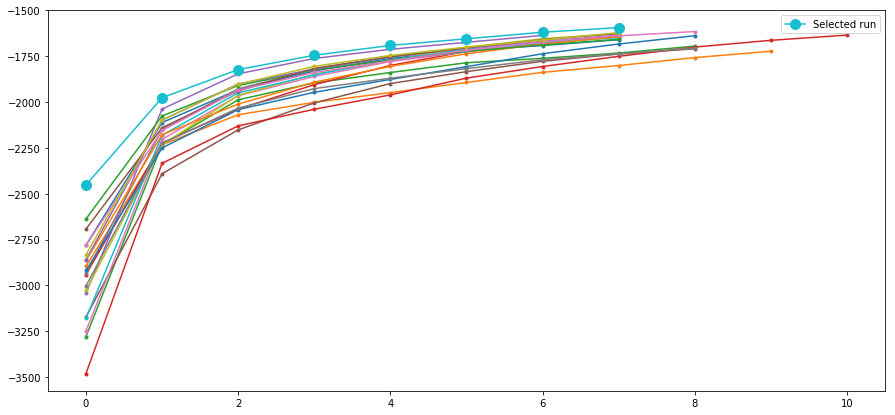

In [16]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Compare trained models

In [13]:
#Import it:
from code.evaluation import Evaluation_metrics

In [14]:
evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result
 ====  ===  ==========  ============
  ..         Accuracy    F1 (micro)
====  ===  ==========  ============
   0  All       0.955         0.955
====  ===  ==========  ============
Test
A result
 ====  ===  ==========  ============
  ..         Accuracy    F1 (micro)
====  ===  ==========  ============
   0  All    0.906566      0.906566
====  ===  ==========  ============


In [ ]:
#upper bound global confusion matrix..
prob_Yz = generate_confusionM(Z_train_pred, label_I.y_obs_repeat)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)

*** Soft-Majority (Train with softMV) ***
Train
Calculate confusion matrix on repeat version


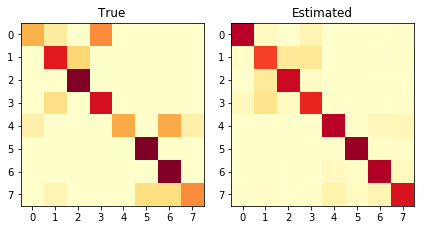

JS divergence: 0.1224	Norm Frobenius: 0.1300


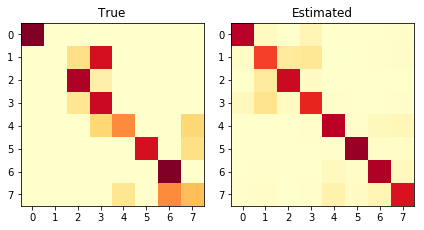

JS divergence: 0.1770	Norm Frobenius: 0.1613


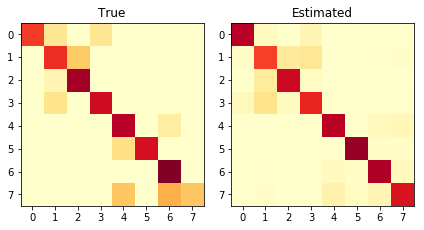

JS divergence: 0.0879	Norm Frobenius: 0.0974


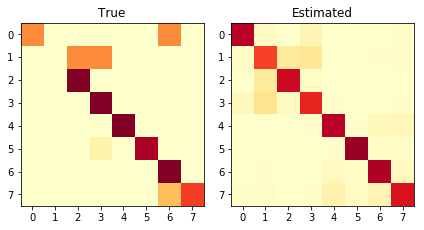

JS divergence: 0.1755	Norm Frobenius: 0.1467


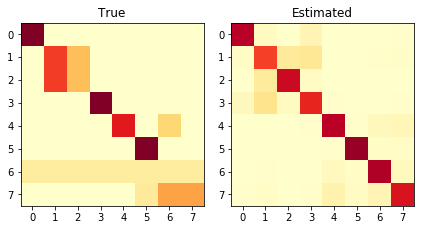

JS divergence: 0.1830	Norm Frobenius: 0.1652


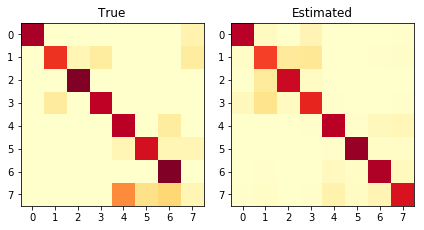

JS divergence: 0.1154	Norm Frobenius: 0.1195


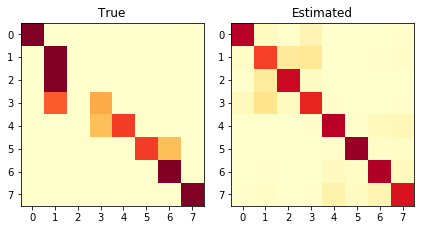

JS divergence: 0.2061	Norm Frobenius: 0.1893


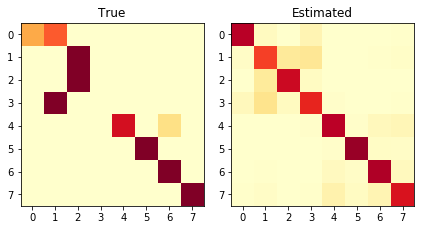

JS divergence: 0.2528	Norm Frobenius: 0.2205


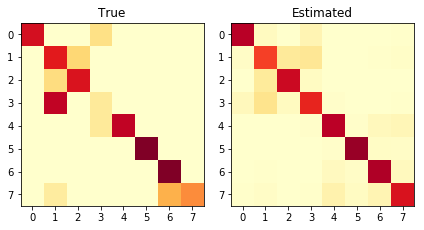

JS divergence: 0.1182	Norm Frobenius: 0.1318


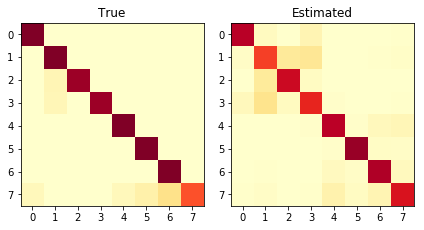

JS divergence: 0.0730	Norm Frobenius: 0.0744


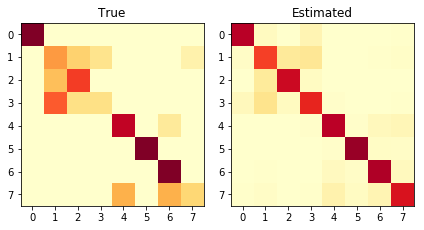

JS divergence: 0.1103	Norm Frobenius: 0.1325


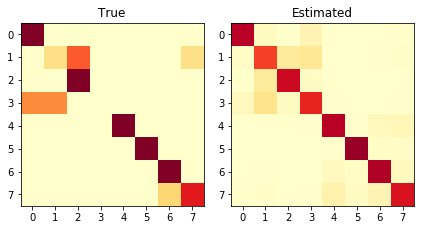

JS divergence: 0.1729	Norm Frobenius: 0.1515


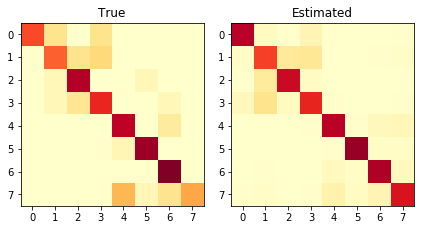

JS divergence: 0.0695	Norm Frobenius: 0.0800


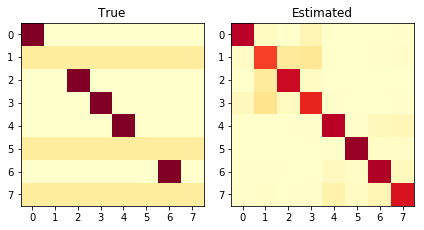

JS divergence: 0.2282	Norm Frobenius: 0.1701


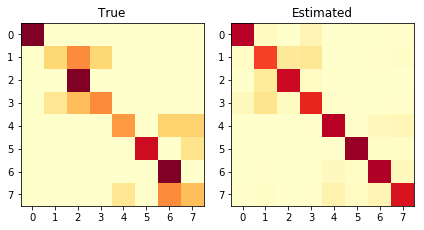

JS divergence: 0.1273	Norm Frobenius: 0.1396
Calculate confusion matrix on global version


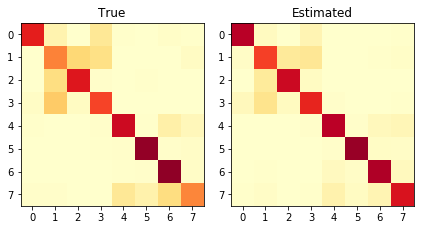

JS divergence: 0.0242	Norm Frobenius: 0.0566
A result


Accuracy  F1 (micro)  (R) NormF mean  (R) JS mean  (R) NormF w  \
0  All     0.826       0.826        0.172003     0.216288     0.121733   

   (R) JS w  (G) NormF    (G) JS  
0  0.122006   0.056558  0.024225

Test
A result


Accuracy  F1 (micro)
0  All  0.794613    0.794613

In [18]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_probas, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_probas)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train
Calculate confusion matrix on repeat version


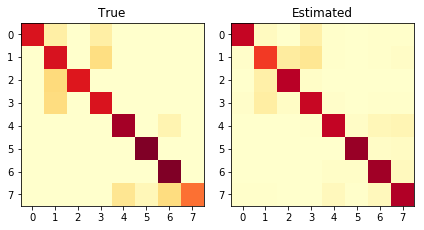

JS divergence: 0.0510	Norm Frobenius: 0.0650


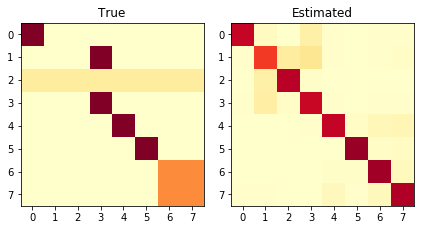

JS divergence: 0.2464	Norm Frobenius: 0.2055


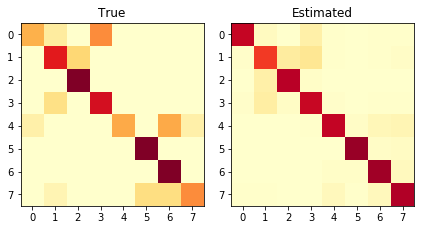

JS divergence: 0.1153	Norm Frobenius: 0.1279


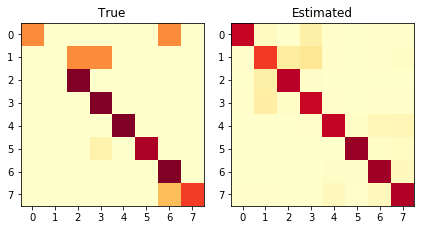

JS divergence: 0.1641	Norm Frobenius: 0.1445


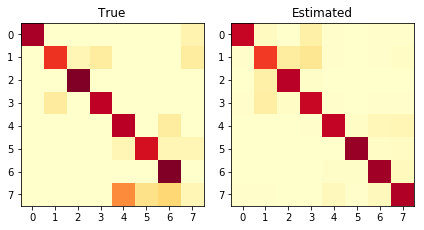

JS divergence: 0.1245	Norm Frobenius: 0.1305


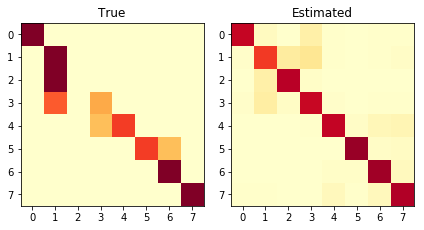

JS divergence: 0.2129	Norm Frobenius: 0.1991


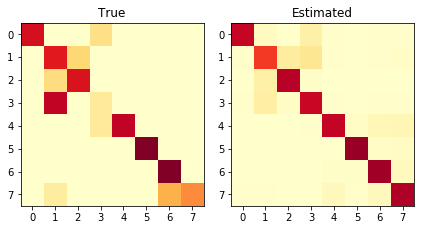

JS divergence: 0.1306	Norm Frobenius: 0.1499


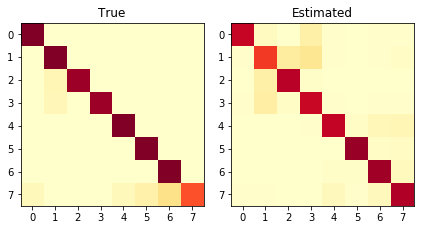

JS divergence: 0.0697	Norm Frobenius: 0.0743


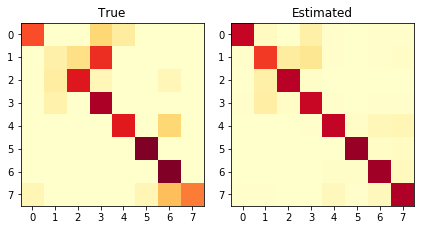

JS divergence: 0.1062	Norm Frobenius: 0.1262


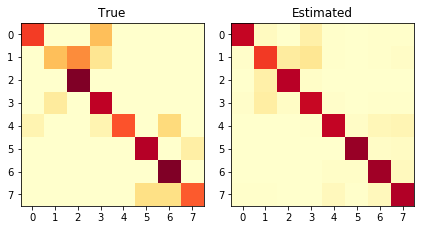

JS divergence: 0.0894	Norm Frobenius: 0.1000


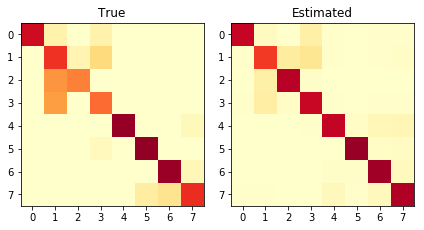

JS divergence: 0.0635	Norm Frobenius: 0.0917


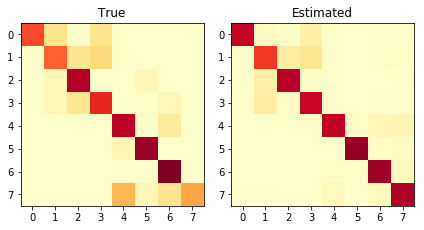

JS divergence: 0.0726	Norm Frobenius: 0.0888


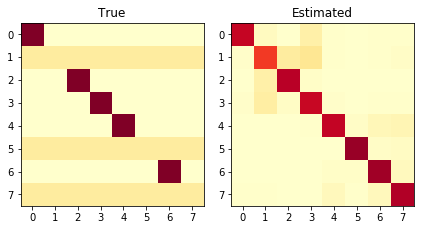

JS divergence: 0.2350	Norm Frobenius: 0.1752


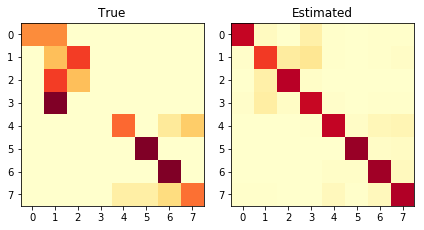

JS divergence: 0.2305	Norm Frobenius: 0.2232


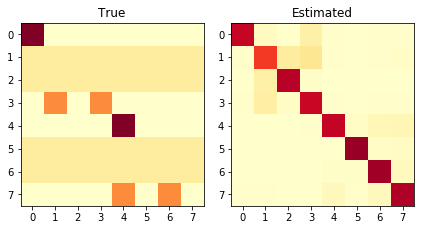

JS divergence: 0.4050	Norm Frobenius: 0.2530
Calculate confusion matrix on global version


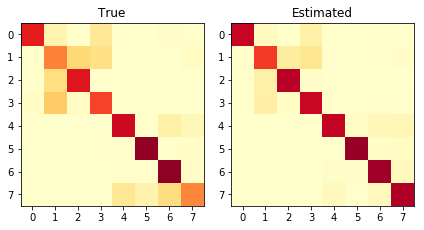

JS divergence: 0.0347	Norm Frobenius: 0.0736
A result


Accuracy  F1 (micro)  (R) NormF mean  (R) JS mean  (R) NormF w  \
0  All     0.804       0.804        0.181207     0.225159     0.130604   

   (R) JS w  (G) NormF    (G) JS  
0   0.12677   0.073609  0.034694

Test
A result


Accuracy  F1 (micro)
0  All   0.79798     0.79798

In [20]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_onehot, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_onehot)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train
Calculate confusion matrix on repeat version


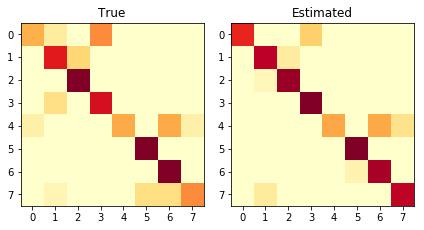

JS divergence: 0.0799	Norm Frobenius: 0.0938


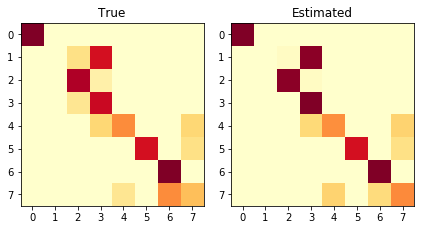

JS divergence: 0.0285	Norm Frobenius: 0.0615


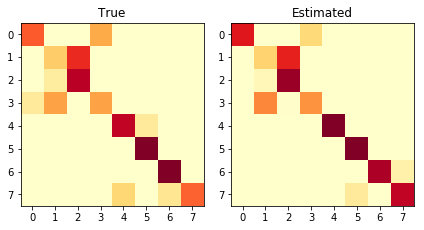

JS divergence: 0.0667	Norm Frobenius: 0.0725


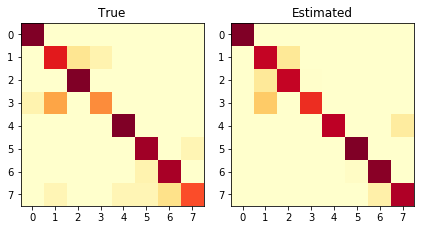

JS divergence: 0.0518	Norm Frobenius: 0.0645


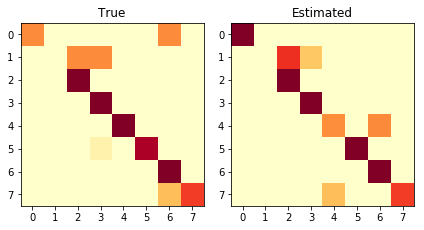

JS divergence: 0.1301	Norm Frobenius: 0.1441


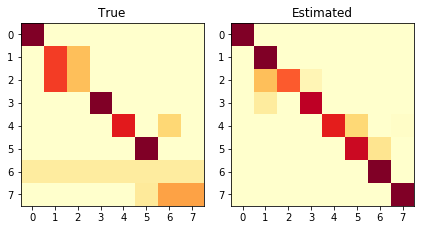

JS divergence: 0.2246	Norm Frobenius: 0.1782


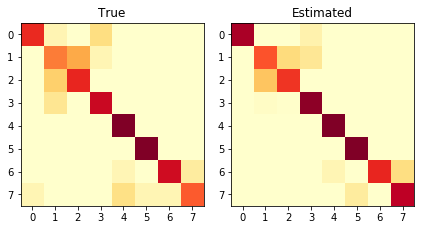

JS divergence: 0.0438	Norm Frobenius: 0.0671


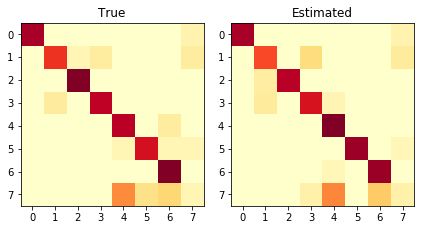

JS divergence: 0.0568	Norm Frobenius: 0.0516


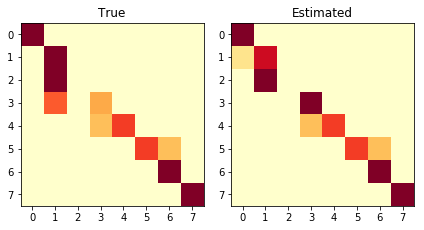

JS divergence: 0.0618	Norm Frobenius: 0.1109


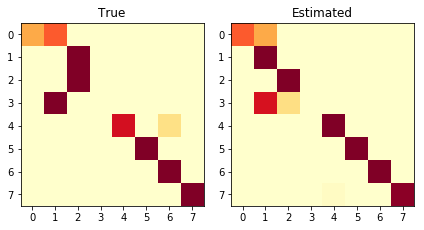

JS divergence: 0.1578	Norm Frobenius: 0.1873


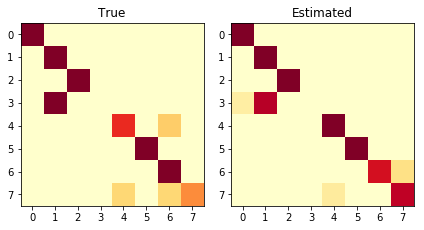

JS divergence: 0.0627	Norm Frobenius: 0.0865


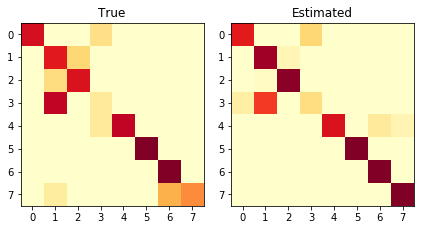

JS divergence: 0.0858	Norm Frobenius: 0.1016


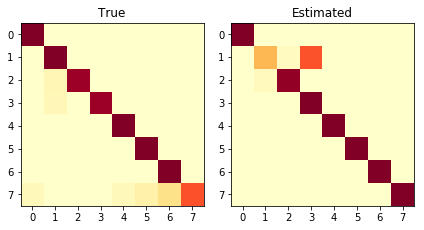

JS divergence: 0.0871	Norm Frobenius: 0.1252


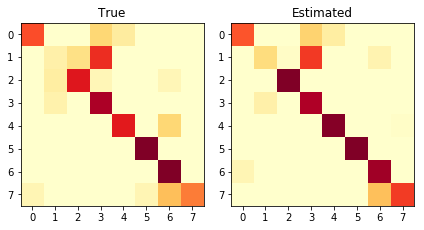

JS divergence: 0.0628	Norm Frobenius: 0.0672


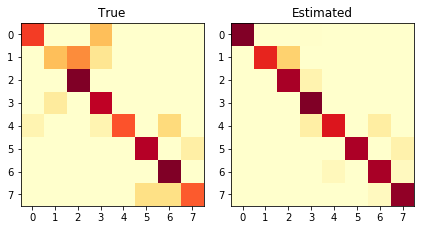

JS divergence: 0.0912	Norm Frobenius: 0.1086
Calculate confusion matrix on global version


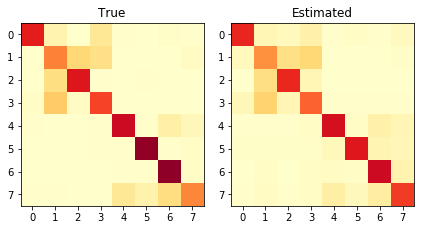

JS divergence: 0.0357	Norm Frobenius: 0.0468
A result


Accuracy  F1 (micro)  (R) NormF mean  (R) JS mean  (R) NormF w  \
0  All     0.864       0.864        0.139434      0.15302     0.098342   

   (R) JS w  (G) NormF   (G) JS  
0  0.085778   0.046829  0.03573

Test
A result


Accuracy  F1 (micro)
0  All  0.835859    0.835859

In [22]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = ds_conf.mean(axis=0))

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train
Calculate confusion matrix on repeat version


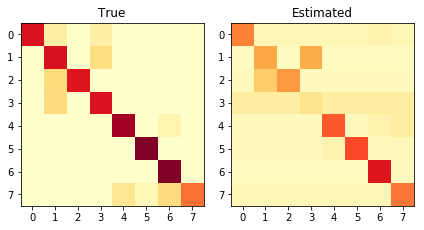

JS divergence: 0.2167	Norm Frobenius: 0.1388


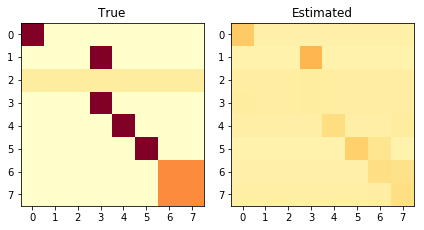

JS divergence: 0.4517	Norm Frobenius: 0.2420


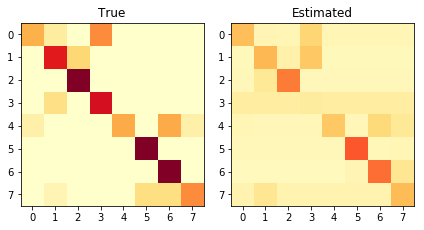

JS divergence: 0.2862	Norm Frobenius: 0.1646


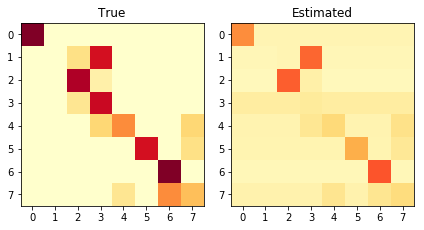

JS divergence: 0.2891	Norm Frobenius: 0.1635


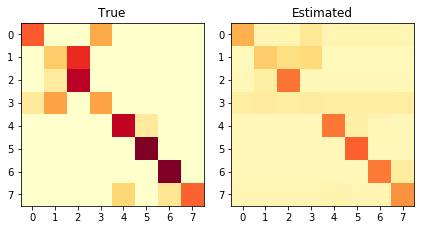

JS divergence: 0.2775	Norm Frobenius: 0.1520


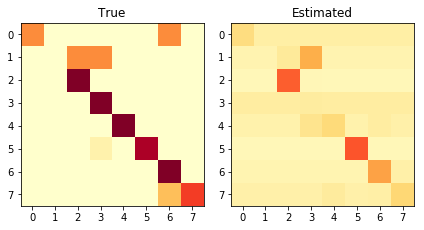

JS divergence: 0.4123	Norm Frobenius: 0.2159


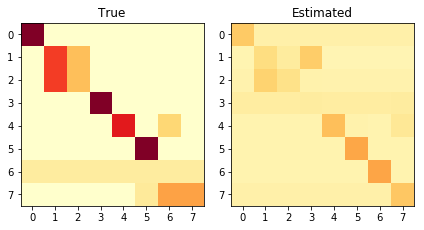

JS divergence: 0.3981	Norm Frobenius: 0.2144


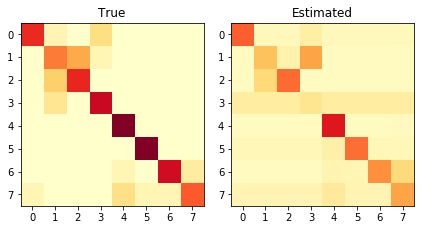

JS divergence: 0.2142	Norm Frobenius: 0.1443


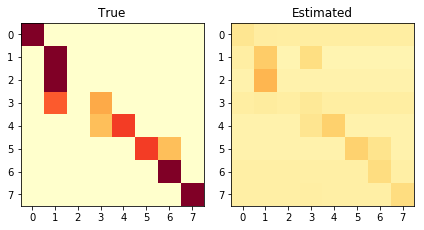

JS divergence: 0.4964	Norm Frobenius: 0.2515


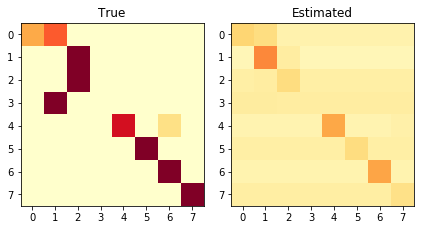

JS divergence: 0.5326	Norm Frobenius: 0.2757


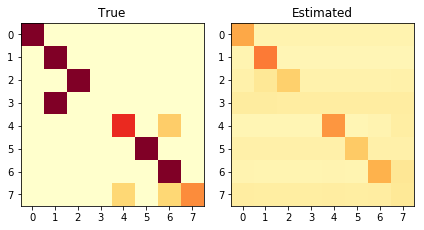

JS divergence: 0.4382	Norm Frobenius: 0.2335


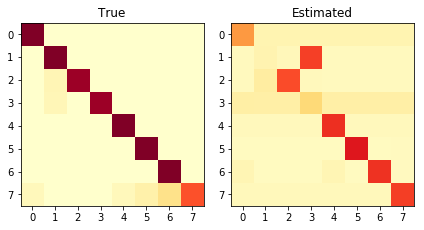

JS divergence: 0.2959	Norm Frobenius: 0.2018


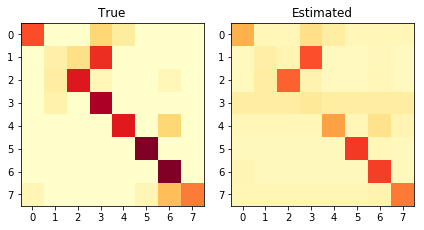

JS divergence: 0.2205	Norm Frobenius: 0.1416


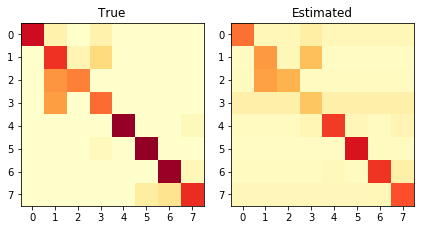

JS divergence: 0.1647	Norm Frobenius: 0.1021


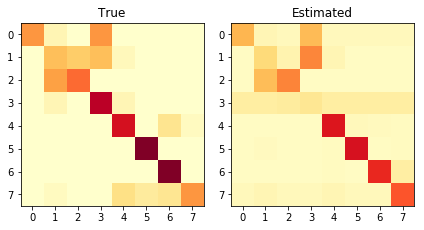

JS divergence: 0.1693	Norm Frobenius: 0.1229
Calculate confusion matrix on global version


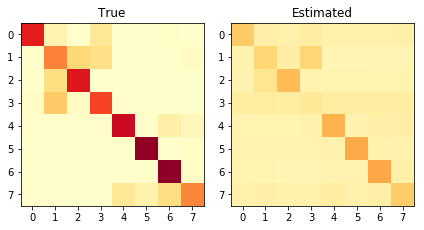

JS divergence: 0.2774	Norm Frobenius: 0.1762
A result


Accuracy  F1 (micro)  (R) NormF mean  (R) JS mean  (R) NormF w  \
0  All     0.746       0.746        0.189759     0.319859     0.164402   

   (R) JS w  (G) NormF   (G) JS  RMSE mean    RMSE w  
0  0.274857   0.176225  0.27739     0.0681  0.050255

A result


ACC imiting Annot mean  Cross-entropy mean  ACC imiting Annot wmean  \
0                 0.80951             1.16896                 0.783274   

   Cross entropy wmean  
0              0.95573

Test
A result


Accuracy  F1 (micro)
0  All  0.736532    0.736532

In [25]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt,conf_true_G =confe_matrix_G, conf_pred_G = prob_Yzt.mean(axis=0))

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train
Calculate confusion matrix on repeat version


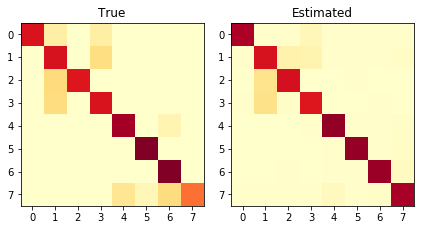

JS divergence: 0.0568	Norm Frobenius: 0.0647
Groups probabilities:  [1. 0. 0.]


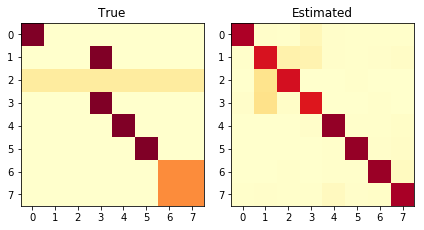

JS divergence: 0.2580	Norm Frobenius: 0.2147
Groups probabilities:  [1. 0. 0.]


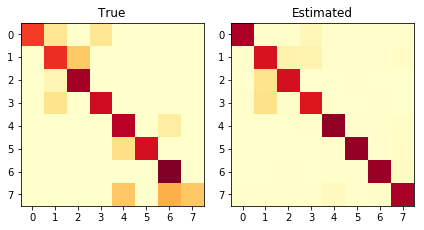

JS divergence: 0.1055	Norm Frobenius: 0.1152
Groups probabilities:  [1. 0. 0.]


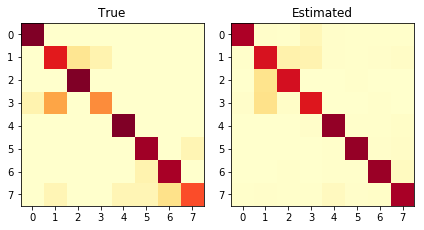

JS divergence: 0.0630	Norm Frobenius: 0.0747
Groups probabilities:  [1. 0. 0.]


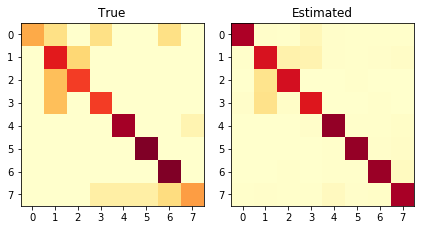

JS divergence: 0.0955	Norm Frobenius: 0.1088
Groups probabilities:  [1. 0. 0.]


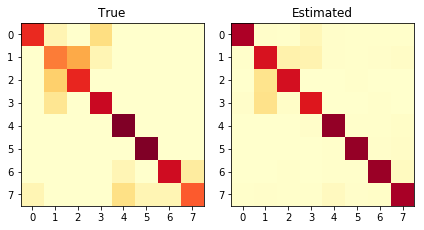

JS divergence: 0.0582	Norm Frobenius: 0.0805
Groups probabilities:  [1. 0. 0.]


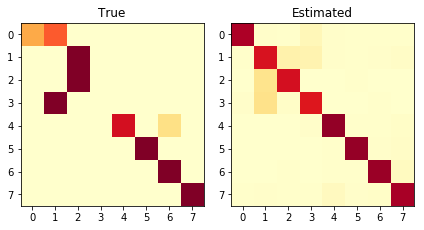

JS divergence: 0.2612	Norm Frobenius: 0.2322
Groups probabilities:  [1. 0. 0.]


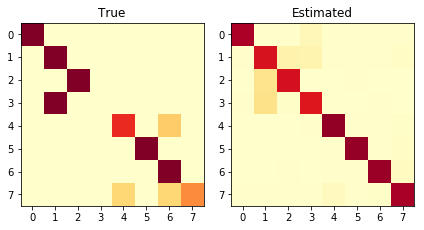

JS divergence: 0.1660	Norm Frobenius: 0.1683
Groups probabilities:  [1. 0. 0.]


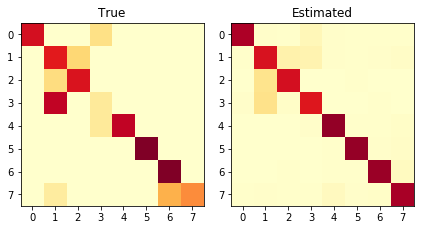

JS divergence: 0.1125	Norm Frobenius: 0.1401
Groups probabilities:  [1. 0. 0.]


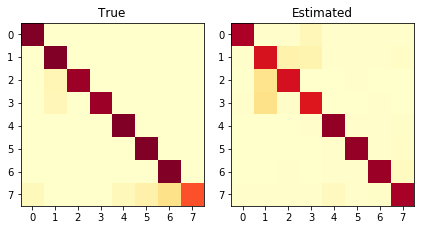

JS divergence: 0.0591	Norm Frobenius: 0.0678
Groups probabilities:  [1. 0. 0.]


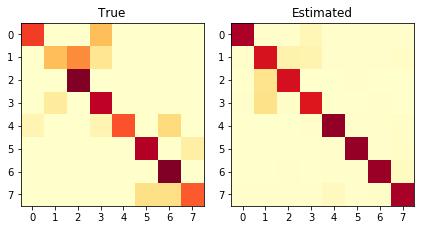

JS divergence: 0.1160	Norm Frobenius: 0.1231
Groups probabilities:  [1. 0. 0.]


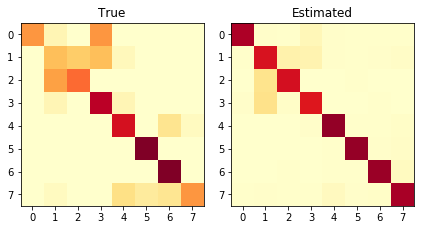

JS divergence: 0.1125	Norm Frobenius: 0.1342
Groups probabilities:  [1. 0. 0.]


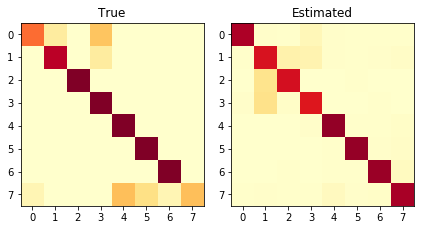

JS divergence: 0.1083	Norm Frobenius: 0.1159
Groups probabilities:  [1. 0. 0.]


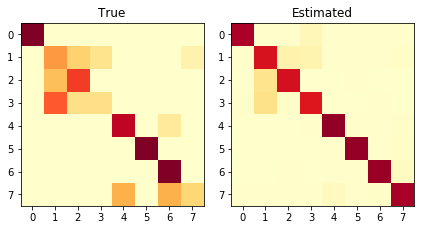

JS divergence: 0.1312	Norm Frobenius: 0.1512
Groups probabilities:  [1. 0. 0.]


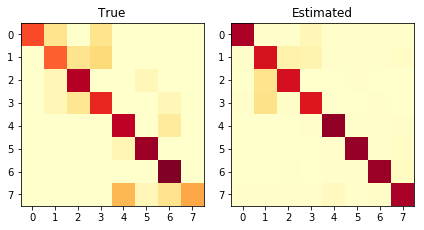

JS divergence: 0.0953	Norm Frobenius: 0.1030
Groups probabilities:  [1. 0. 0.]
Calculate confusion matrix on global version


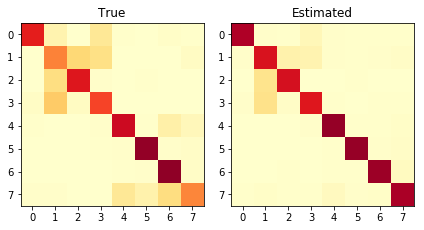

JS divergence: 0.0501	Norm Frobenius: 0.0816
A result


Accuracy  F1 (micro)  (R) NormF mean  (R) JS mean  (R) NormF w  \
0  All     0.846       0.846        0.184974     0.229833     0.135103   

   (R) JS w  (G) NormF    (G) JS  RMSE mean    RMSE w  
0  0.134873   0.081553  0.050129   0.142772  0.109541

A result


ACC imiting Annot mean  Cross-entropy mean  ACC imiting Annot wmean  \
0                0.770572            0.637595                 0.794268   

   Cross entropy wmean  
0             0.598379

Test


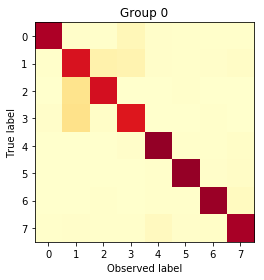

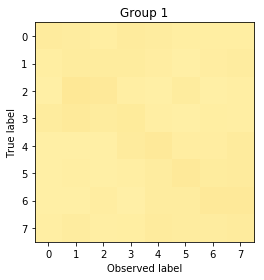

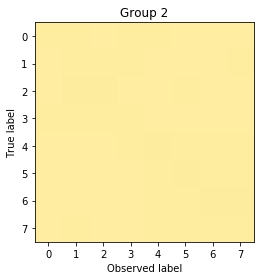

Inertia JS: 0.34419904521066996
Inertia NormF: 0.19214670080691576
A result


Groups      Prob  T(g)   Entropy  Diag mean  Isim (JS)   Spammer   Iner JS  \
0       0  0.995731    58  0.477869   0.878325   0.906288  0.860943  0.344199   
1       1  0.003199     0  2.075510   0.141021   0.001326  0.018310  0.344199   
2       2  0.001071     0  2.079218   0.128663  -0.025960  0.004187  0.344199   

   Iner NormF  Accuracy  F1 (micro)  
0    0.192147  0.830808    0.830808  
1    0.192147  0.603535    0.603535  
2    0.192147  0.592593    0.592593

A result


Accuracy  F1 (micro)
0  All  0.828283    0.828283

In [29]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Global.calculate_Yz()
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours Global multiples runs***
Train
Calculate confusion matrix on repeat version


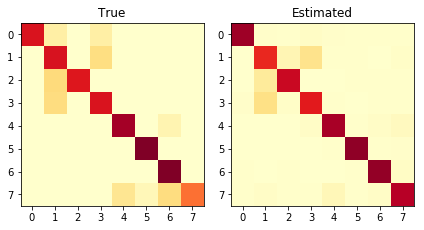

JS divergence: 0.0524	Norm Frobenius: 0.0616
Groups probabilities:  [1. 0. 0.]


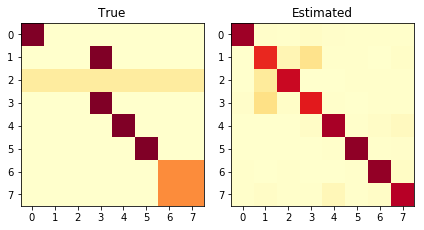

JS divergence: 0.2417	Norm Frobenius: 0.2060
Groups probabilities:  [1. 0. 0.]


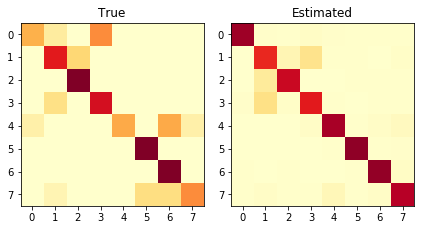

JS divergence: 0.1481	Norm Frobenius: 0.1447
Groups probabilities:  [1. 0. 0.]


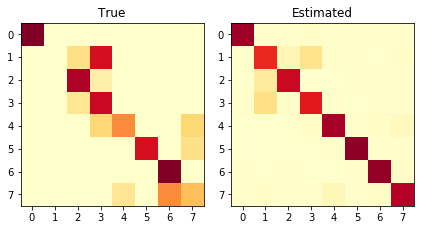

JS divergence: 0.1931	Norm Frobenius: 0.1726
Groups probabilities:  [1. 0. 0.]


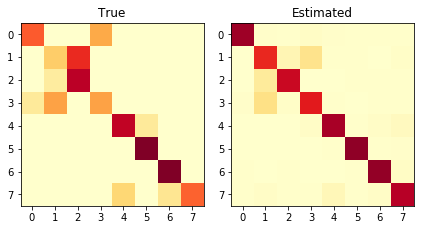

JS divergence: 0.1274	Norm Frobenius: 0.1398
Groups probabilities:  [1. 0. 0.]


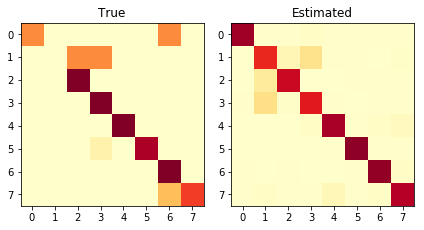

JS divergence: 0.1748	Norm Frobenius: 0.1561
Groups probabilities:  [1. 0. 0.]


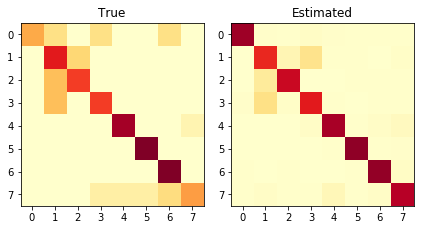

JS divergence: 0.1055	Norm Frobenius: 0.1133
Groups probabilities:  [1. 0. 0.]


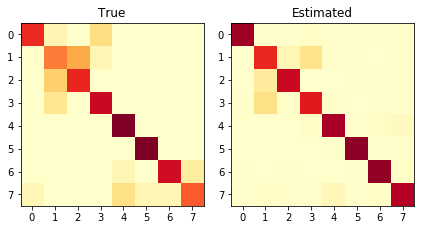

JS divergence: 0.0699	Norm Frobenius: 0.0836
Groups probabilities:  [1. 0. 0.]


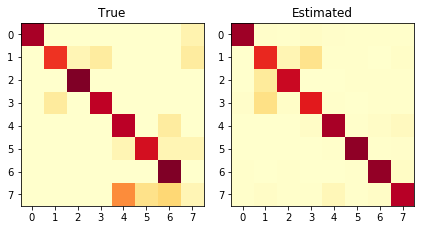

JS divergence: 0.1269	Norm Frobenius: 0.1314
Groups probabilities:  [1. 0. 0.]


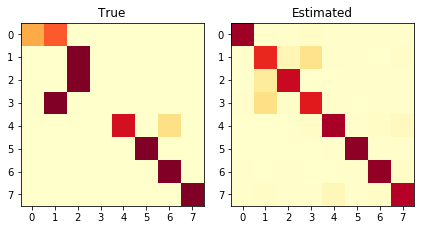

JS divergence: 0.2612	Norm Frobenius: 0.2297
Groups probabilities:  [1. 0. 0.]


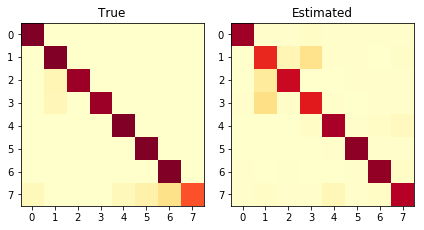

JS divergence: 0.0625	Norm Frobenius: 0.0708
Groups probabilities:  [1. 0. 0.]


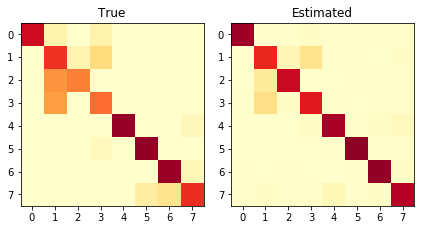

JS divergence: 0.0594	Norm Frobenius: 0.0797
Groups probabilities:  [1. 0. 0.]


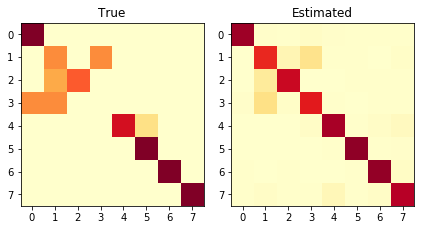

JS divergence: 0.1384	Norm Frobenius: 0.1397
Groups probabilities:  [1. 0. 0.]


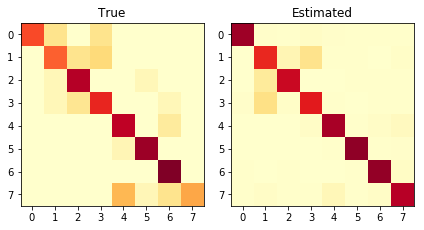

JS divergence: 0.0898	Norm Frobenius: 0.0970
Groups probabilities:  [1. 0. 0.]


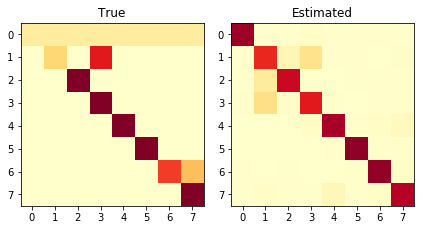

JS divergence: 0.1653	Norm Frobenius: 0.1608
Groups probabilities:  [1. 0. 0.]
Calculate confusion matrix on global version


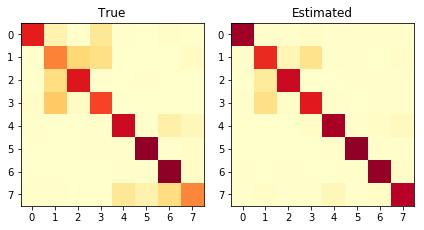

JS divergence: 0.0465	Norm Frobenius: 0.0758
A result


Accuracy  F1 (micro)  (R) NormF mean  (R) JS mean  (R) NormF w  \
0  All     0.837       0.837        0.181996     0.227334     0.132091   

   (R) JS w  (G) NormF    (G) JS  RMSE mean    RMSE w  
0  0.132706    0.07576  0.046477   0.135706  0.102081

A result


ACC imiting Annot mean  Cross-entropy mean  ACC imiting Annot wmean  \
0                0.770057             0.63497                 0.793483   

   Cross entropy wmean  
0             0.594904

Test


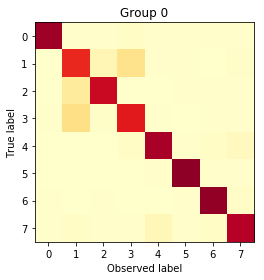

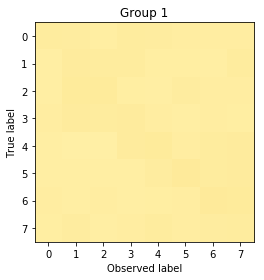

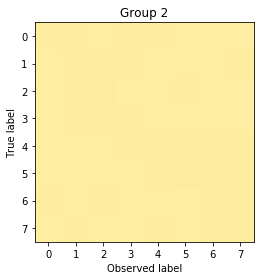

Inertia JS: 0.3439493953108442
Inertia NormF: 0.19042420216525593
A result


Groups      Prob  T(g)   Entropy  Diag mean  Isim (JS)  S_raykar  \
0       0  0.996456    58  0.493328   0.870775   0.899570  0.852314   
1       1  0.002503     0  2.077417   0.136850  -0.007748  0.013543   
2       2  0.001040     0  2.079253   0.128435  -0.026476  0.003925   

   S_bias entrop  S_bias median   Iner JS  Iner NormF  Accuracy  F1 (micro)  
0       2.078517       0.012041  0.343949    0.190424  0.822391    0.822391  
1       2.079257       0.004037  0.343949    0.190424  0.574916    0.574916  
2       2.079423       0.001266  0.343949    0.190424  0.693603    0.693603

A result


Accuracy  F1 (micro)
0  All  0.823232    0.823232

In [14]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Global.calculate_Yz()
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours Global multiples runs***
Train
Calculate confusion matrix on repeat version


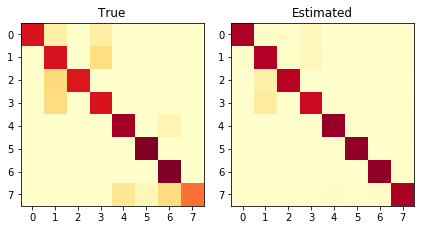

JS divergence: 0.0561	Norm Frobenius: 0.0692
Groups probabilities:  [1. 0.]


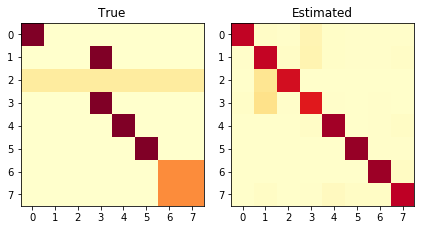

JS divergence: 0.2626	Norm Frobenius: 0.2178
Groups probabilities:  [0.75 0.25]


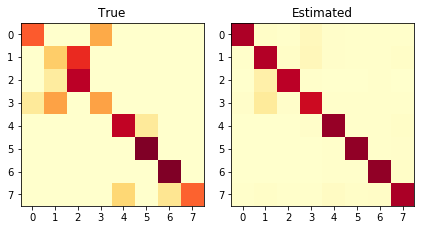

JS divergence: 0.1411	Norm Frobenius: 0.1560
Groups probabilities:  [1. 0.]


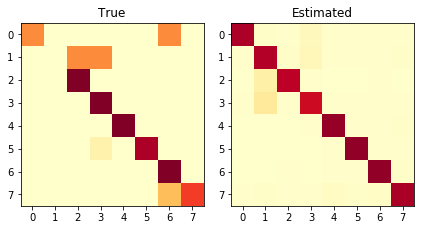

JS divergence: 0.1975	Norm Frobenius: 0.1722
Groups probabilities:  [1. 0.]


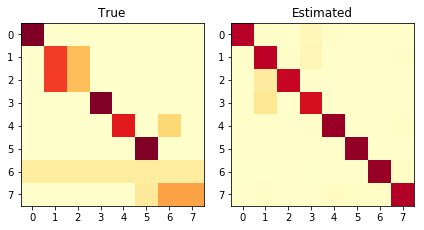

JS divergence: 0.2072	Norm Frobenius: 0.1797
Groups probabilities:  [0.89 0.11]


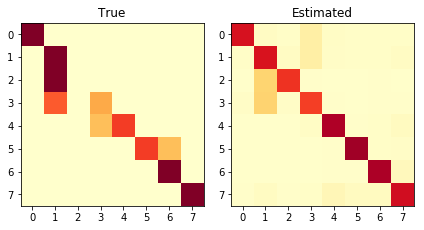

JS divergence: 0.1702	Norm Frobenius: 0.1627
Groups probabilities:  [0.38 0.62]


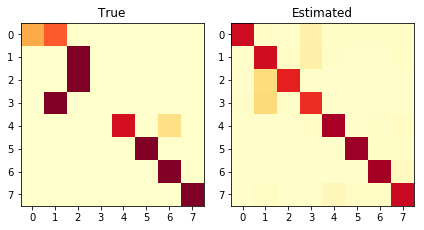

JS divergence: 0.2850	Norm Frobenius: 0.2315
Groups probabilities:  [0.53 0.47]


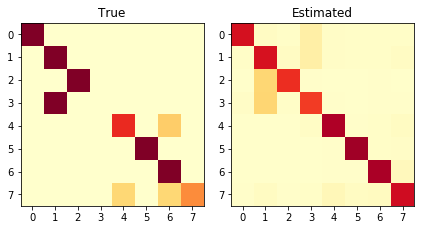

JS divergence: 0.1696	Norm Frobenius: 0.1569
Groups probabilities:  [0.42 0.58]


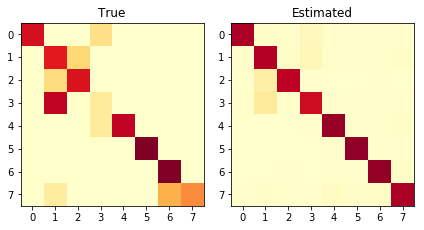

JS divergence: 0.1273	Norm Frobenius: 0.1501
Groups probabilities:  [0.98 0.02]


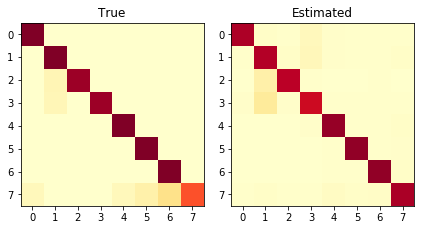

JS divergence: 0.0440	Norm Frobenius: 0.0535
Groups probabilities:  [1. 0.]


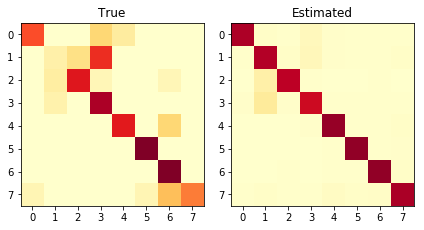

JS divergence: 0.1499	Norm Frobenius: 0.1580
Groups probabilities:  [1. 0.]


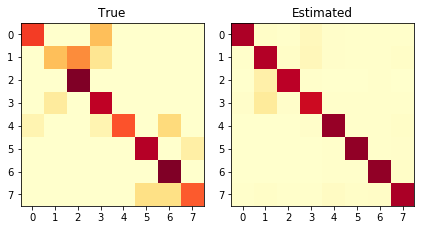

JS divergence: 0.1263	Norm Frobenius: 0.1305
Groups probabilities:  [1. 0.]


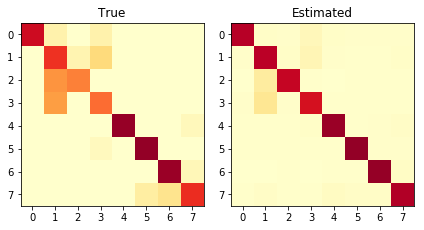

JS divergence: 0.0669	Norm Frobenius: 0.0891
Groups probabilities:  [0.9 0.1]


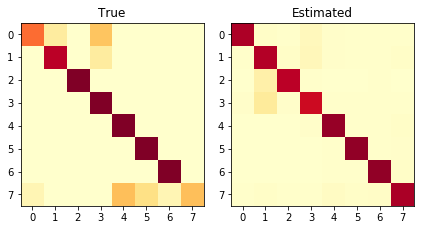

JS divergence: 0.0949	Norm Frobenius: 0.1091
Groups probabilities:  [1. 0.]


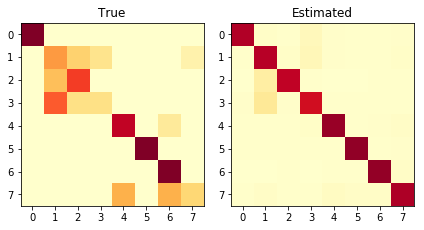

JS divergence: 0.1541	Norm Frobenius: 0.1626
Groups probabilities:  [0.95 0.05]
A result


Accuracy  F1 (micro)  (R) NormF mean  (R) JS mean  (R) NormF w  \
0  All     0.845       0.845        0.185706     0.231348     0.138922   

   (R) JS w  RMSE mean    RMSE w  
0  0.141252    0.15346  0.118178

A result


ACC imiting Annot mean  Cross-entropy mean  ACC imiting Annot wmean  \
0                0.779178            0.568507                 0.814291   

   Cross entropy wmean  
0              0.52548

Test


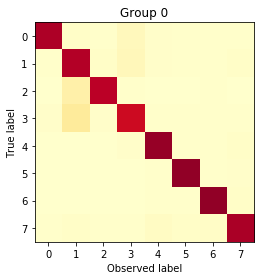

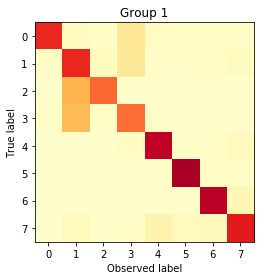

Inertia JS: 0.038254814490692714
Inertia NormF: 0.08064694702625275
A result


Groups      Prob  T(g)   Entropy  Diag mean  Isim (JS)   Spammer   Iner JS  \
0       0  0.701761    41  0.408477   0.910713   0.932810  0.897957  0.038255   
1       1  0.298239    17  0.842927   0.746574   0.791628  0.710370  0.038255   

   Iner NormF  Accuracy  F1 (micro)  
0    0.080647  0.832492    0.832492  
1    0.080647  0.839226    0.839226

A result


Accuracy  F1 (micro)
0  All  0.826599    0.826599

In [64]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #groups uniform...

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
project confusion matrices